In [89]:
import random

def interarrival_time():
    return random.expovariate(2*LAMBDA)

def request_type():
    if random.random() < 0.5:
        return "storage"
    else:
        return "recovery"  

def request_level():
    return random.randint(1,L)

In [90]:
"définition du système"

import heapq #on utilise une heap pour maintenir l'échéancier ; y place un élément en O(log n), récupère le premier en O(1)

#classe Système, contient le système, mais aussi l'échéancier

class System(object):
     
    def __init__(self):
        self.schedule = [] #échéancier
        self.queues = Queues() #les différentes files d'attente des requêtes
        self.lift = Lift()
        self.requests = [] #la liste des clients
        
#classe request
        
class Request(object):
    
    def __init__(self, i):
        self.id = i #identifiant de la requête
        self.arrival = -1 #instant d'arrivée
        self.end_waiting = -1 #instant de prise en charge
        self.type = request_type() #storage ou recovery
        self.level_init = 0
        self.level_final = 0
        
        if self.type == "storage":
            self.level_final = request_level() #étage cible de la requête
            
        if self.type == "recovery":
            self.level_init = request_level() #étage initial de la requête
    
    def __str__(self):
        return f"Request(id={self.id}, arrival={self.arrival}, end_waiting={self.end_waiting}, type={self.type}, level_init={self.level_init}, level_final={self.level_final})"


        
#classe ascenseur

class Lift(object):
    
    def __init__(self):
        self.level = 0 #étage cible de l'ascenseur, ou celui où il est en attente
        self.status = "idle" #idle or active
        self.request_handled = -1 #numéro de la requête actuellement servie, -1 si aucune

#classe files d'attente
        
class Queues(object):
    
    def __init__(self):
        self.level = [] #contient la liste des requêtes en attente à chaque étage
        for l in range(L+1):
            self.level.append([])

In [91]:
"définition des événements"

#classe événement

class Event(object):
    
    def __init__(self, time):
        self.time = time
        self.type = ""

#sous-classe "fin de simulation"

class Event_end(Event):
    
    def __init__(self, time):
        self.time = time
        self.type = "fin"

#sous-classe "arrivée d'une requête"

class Event_arrival(Event):
    
    def __init__(self, time):
        self.time = time
        self.type = "request_arrival"
    
    def action(self, sys):
        request = Request(len(sys.requests))
        request.arrival = self.time
        sys.requests.append(request)
        
        #print("%.2f" % self.time, ": arrivée requête", request.id, "de type", request.type, request.level_init, "--", request.level_final)
        
        if sys.lift.status == "idle": #on suppose que c'est équivalent à ce qu'aucune autre requête ne soit en attente !!!
            request.end_waiting = self.time + SPEED * abs(sys.lift.level - request.level_init)
            sys.lift.status = "active"
            sys.lift.request_handled = request.id
            sys.lift.level = request.level_final
            service_duration = 2 * TAU + SPEED * abs(request.level_init - request.level_final) 
            e_end_service = Event_end_service(request.end_waiting + service_duration)
            heapq.heappush(sys.schedule, (e_end_service.time, e_end_service))
        else:
            if (request.type == "storage"):
                sys.queues.level[0].append(request)
            if (request.type == "recovery"):
                sys.queues.level[request.level_init].append(request)
         
        e_next_arrival = Event_arrival(self.time + interarrival_time())
        heapq.heappush(sys.schedule, (e_next_arrival.time, e_next_arrival)) 

                
#sous-classe "satisfaction d'une requête"
            
class Event_end_service(Event):
    
    def __init__(self, time):
        self.time = time
        self.type = "request_satisfaction"
    
    def action(self, sys):
        #print("%.2f" % self.time, ": satisfaction requête", sys.lift.request_handled, "à l'étage", sys.lift.level)
        
        warehouse_empty = True
        for j in range(len(sys.queues.level)):
            warehouse_empty = warehouse_empty and (not len(sys.queues.level[j]))
       
        if warehouse_empty:
            sys.lift.status = "idle"
        else:
            l = next_task(sys) #c'est ici qu'on appelle NEXT-TASK
            if not sys.queues.level[l]: #si l'étage choisit par NEXT-TASK est vide
                print("NEXT-TASK a choisi un étage vide !!!")
            else:
                request = sys.queues.level[l].pop(0)
                request.end_waiting = self.time + SPEED * abs(sys.lift.level - l)
                service_duration = 2 * TAU + SPEED * abs(l - request.level_final)
                sys.lift.level = request.level_final
                sys.lift.request_handled = request.id
                e_end_service = Event_end_service(request.end_waiting + service_duration)
                heapq.heappush(sys.schedule, (e_end_service.time, e_end_service))        

In [92]:
"Différentes versions de NEXT-TASK : c'est ici qu'il faut les implémenter"

def next_task(sys):
    if NEXT_TASK == "FIFO":
        return fifo(sys)
    if NEXT_TASK == "GREEDY": #si par exemple vous avez codé ci-dessous une version GREEDY de NEXT_TASK
        return greedy(sys)
    if NEXT_TASK == "KGREEDY":
        K=3
        return kgreedy(sys, K)
    if NEXT_TASK == "REPLAN":
        return replan(sys)
    
def fifo(sys):
    earliest_time = TOTAL_DURATION
    l = -1
    for j in range(len(sys.queues.level)):
        if len(sys.queues.level[j]) > 0:
            if sys.queues.level[j][0].arrival < earliest_time:
                earliest_time = sys.queues.level[j][0].arrival
                l = j
    return l



Le code pour replan nécessite de trouver l'optimal de l'instance au moment de l'appel. Pour cela, on peut modéliser le problème comme un problème de plus court chemin sur un graphe acyclique (on voit le graph comme un réseau de noeuds, de taille (L+1)^tache à chaque couche, et avec len(tache) couches). En prenant comme cout la distance entre la position finale de l'assenseur et l'étage de départ d'une tâche suivante possible, on obtient un graphe acyclique, qui peut donc être résolu en temps linéaire en la taille du graphe ()

## K-Greedy et Replan

L'objectif de Replan est de résoudre l'instance lorsqu'une tâche a été effectuée pour choisir la nouvelle tâche. Malgré nos efforts, nous n'avons pas trouvé de façon satisfaisante pour modéliser le problème sous forme de graphe (nous avons trouvé un graphe représentant notre système et dont la résolution est en temps linéaire (ordre topologique), mais le nombre de noeuds est exponentiel en le nombre de tâche). La résolution de Replan est donc compliqué selon le nombre de tâche à réaliser.

Pour cela, nous souhaitions implémenter une politique "K-Greedy" (cette politique a peut-être un autre nom dans la littérature, mais nous ne l'avons pas trouvé). Elle consiste à regarder l'ensemble des combinaisons de K tâches, et de trouver celle minimisant le temps à vide de l'assensseur. On peut remarquer que K-Greedy est équivalent à Replan lorsque K est supérieur ou égal au nombre maximal de tâche. 

In [93]:
L=7

def indices(n,k,L=L):
    list_indices = [0 for _ in range(k)]
    occurence = [0 for i in range(L+1)]
    r=n
    for i in range(k):
        list_indices[-1-i] = r // ((L+1)**(k-1-i))
        r = r - list_indices[-1-i]*((L+1)**(k-1-i))
        occurence[list_indices[-1-i]] += 1
    return list_indices, occurence

def combi_possible(occurence,queue_size):
    for i in range(L+1):
        if queue_size[i] < occurence[i]:
            return False
    return True

import copy
def kgreedy(systeme, k, debug=False):
    sys = copy.deepcopy(systeme)
    k = min(k,sum([len(sys.queues.level[i]) for i in range(L+1)]))
    best_path = None
    best_time = (L+1) * k
    queue_size =[len(sys.queues.level[i]) for i in range(L+1)]
    #print("queues : ",queue_size)
    for n in range((L+1)**(k)): 
        list_indices, occurence = indices(n,k)
        #print(occurence)
        if combi_possible(occurence,queue_size):
            #print("occurence : ",occurence)
            queue = [sys.queues.level[i].copy() for i in range(L+1)]
            time = 0
            lift_level = sys.lift.level
            for i in range(len(list_indices)):
                indice = list_indices[i]
                #print([len(queue[i]) for i in range(L+1)])
                #print(indice)
                task = queue[indice].pop(0)
                time += abs(lift_level - task.level_init)
                lift_level = task.level_final
            if time < best_time:
                #print("New best time : ",time," for ", list_indices)
                best_time = time
                best_path = list_indices.copy()
                if best_time == 0:
                    if debug:
                        return best_path[0], best_path, best_time
                    return best_path[0]
        
    if debug:
        return best_path[0], best_path, best_time
    return best_path[0]

def test_kgreedy():
    sys = System()
    random.seed(9)
    for i in range(10):
        request=Request(i)
        sys.queues.level[request.level_init].append(request)
        print(request)
    print(kgreedy(sys,5, True))  

test_kgreedy()

def replan(sys):
    return kgreedy(sys, sum([len(sys.queues.level[i]) for i in range(L+1)]))





Request(id=0, arrival=-1, end_waiting=-1, type=storage, level_init=0, level_final=3)
Request(id=1, arrival=-1, end_waiting=-1, type=storage, level_init=0, level_final=2)
Request(id=2, arrival=-1, end_waiting=-1, type=recovery, level_init=1, level_final=0)
Request(id=3, arrival=-1, end_waiting=-1, type=storage, level_init=0, level_final=4)
Request(id=4, arrival=-1, end_waiting=-1, type=recovery, level_init=1, level_final=0)
Request(id=5, arrival=-1, end_waiting=-1, type=storage, level_init=0, level_final=5)
Request(id=6, arrival=-1, end_waiting=-1, type=recovery, level_init=6, level_final=0)
Request(id=7, arrival=-1, end_waiting=-1, type=storage, level_init=0, level_final=6)
Request(id=8, arrival=-1, end_waiting=-1, type=recovery, level_init=6, level_final=0)
Request(id=9, arrival=-1, end_waiting=-1, type=storage, level_init=0, level_final=2)
(0, [0, 1, 0, 1, 0], 3)


In [94]:
"Lance la simulation, nombre de réplications donné par NBR_RUNS"

from statistics import mean

LAMBDA = 0.02 #intensité des deux processus d'arrivées : nombre moyen d'arrivées par unité de temps
L = 7 #nombre d'étages
TAU = 1 #temps de charge et décharge
SPEED = 1 #nombre d'étages parcourus par seconde
NBR_RUNS = 20 # nombre de réplications
CONFIDENCE_LEVEL = 95 #pourcentage donnant le niveau de confiance des résultats
TOTAL_DURATION = 20000 #durée totale simulée
TRANSIENT_DURATION = 10000 #temps estimé pour arriver en régime transient
NEXT_TASK = "REPLAN" #pour choisir la version de NEXT-TASK

waiting_times_run = [] #contient le temps moyen d'attente pour chaque run

for i in range(NBR_RUNS):
    random.seed(i) #permet de la reproductibilité
    sys = System()
    #e_fin = Event_end(TOTAL_DURATION)
    #heapq.heappush(sys.schedule, (e_fin.time, e_fin))
    e = Event_arrival(0)
    heapq.heappush(sys.schedule, (e.time, e))
    
    while e.time < TOTAL_DURATION:
        (time, e) = heapq.heappop(sys.schedule)
        e.action(sys)
    
    waiting_times_requests = [] #temps d'attente par client pour la réplication i courante
   
    for j in range(len(sys.requests)):
        #on ne garde que les requêtes qui sont arrivées en régime permanent et qui ont quitté l'entrepôt'
        if sys.requests[j].end_waiting != -1 and sys.requests[j].arrival >= TRANSIENT_DURATION:
            waiting_times_requests.append(sys.requests[j].end_waiting - sys.requests[j].arrival)
    
    waiting_times_run.append(mean(waiting_times_requests))
    waiting_times_requests.clear()

In [95]:
"Fait l'analyse"

from scipy.stats import t, sem

waiting_mean = mean(waiting_times_run)
waiting_sample_standard_error = sem(waiting_times_run)
confidence_interval = t.interval(CONFIDENCE_LEVEL / 100, NBR_RUNS - 1, waiting_mean, waiting_sample_standard_error)

print("Temps moyen d'attente : %.4f" % waiting_mean)
print("Intervalle de confiance à %d%%: " % CONFIDENCE_LEVEL, end="") ; print("(%.4f, %.4f)" % confidence_interval) 

Temps moyen d'attente : 4.7851
Intervalle de confiance à 95%: (4.6243, 4.9458)


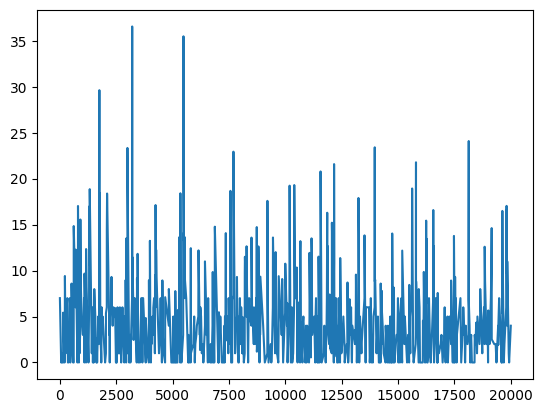

Moyenne empirique : 4.7959


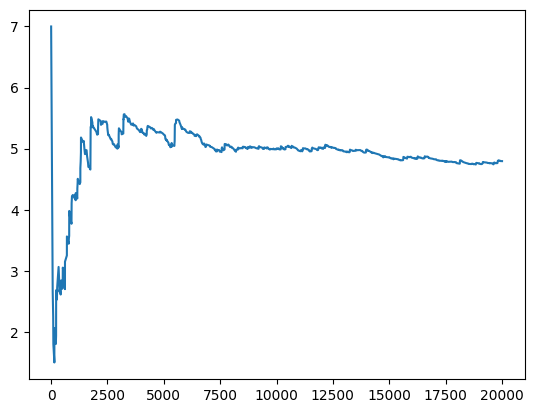

In [96]:
"Tracès sur la dernière réplication"

import matplotlib.pyplot as plt

average_waiting_times = []
total = 0

arrival_times_requests = []
waiting_times_requests = []

for j in range(len(sys.requests)):
    if sys.requests[j].end_waiting != -1:
        arrival_times_requests.append(sys.requests[j].arrival) 
        waiting_times_requests.append(sys.requests[j].end_waiting - sys.requests[j].arrival)

plt.plot(arrival_times_requests,waiting_times_requests)
plt.show()

for j in range(len(waiting_times_requests)):
    total += waiting_times_requests[j]
    average_waiting_times.append(total / (j+1))

print("Moyenne empirique : %.4f" % average_waiting_times[len(waiting_times_requests)-1])

plt.plot(arrival_times_requests,average_waiting_times)
plt.show()